# Project II (Newton vs the machine) - Solving the chaotic three-body problem using deep neural networks as part of Chalmers TIF285

by Matthias Hübl & Linus Stach

## Imports, Inits, Helper functions etc.

Import Numpy, Tensorflow, Keras, Matplotlib and Sklearn

In [144]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

import datetime as time

# Additional imports
from sklearn.model_selection import train_test_split
from keras import models, layers, optimizers, losses, initializers

Test for GPU availibility

In [145]:
devices = tf.config.list_physical_devices('GPU')
print("Available GPUs: ", devices)

Available GPUs:  []


Define constants and hyperparameters

In [155]:
BATCH_SIZE = 10*1000
SEED = 2023
EPOCHS = 10
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1
train = False

Helper functions

In [147]:
def get_data(data, idx):
    """
    Get one training instance from the data set at the index idx. 
    
    The data is assumed to be in an array `data`.
    
    Args:
        idx (int): An integer specifying which of the training example to fetch
        
    Returns:
        x (array): An array of shape (time_steps, 3) which specifies the input to
                   the neural network. The first column is the time and the second
                   and third columns specify the (x, y) coordinates of the second
                   particle. Note that the first particle is always assumed to be
                   at (1, 0) and the third particle can be inferred from the first
                   and second particle's position.
                   
        y (array): An array of shape (time_steps, 4) which specifies the output that 
                   is expected from the neural network.
                   
                   The first two columns specify the (x, y) coordinates of the first
                   particles and the next two columns give the coordinates of the 
                   second particle for the specified time (length of the columns).
                   The third particles position can be inferred from the first
                   and second particle's position.
    """

    x = data[idx, :, [0,3,4]].T
    y = data[idx, :, 1:5]
    assert np.all(y[0,:2] == [1.,0.]),  "first particle should start at (1,0)"
    return x, y

In [148]:
def get_trajectories(pred):
    """
    Gets the trajectories from a predicted output pred.
    
    Args:
        pred (array): An array of shape (N, 4) where N is the number of time
                      steps. The four columns give the positions of the particles
                      1 and 2 for all the time steps.
    Returns:
        p1, p2, p3 (tuple of arrays): Three arrays of dimensions (N, 2) where N is the number 
                             of time steps and the two columns for each array give 
                             the positions of the three particles (p1, p2, p3)
    """
    p1 = pred[:, :2]
    p2 = pred[:, 2:]
    p3 = -p1-p2
    return p1, p2, p3

In [149]:
def plot_trajectories(p1, p2, p3, label, ax=None, **kwargs):
    """
    Plots trajectories for points p1, p2, p3
    
    Args:
        p1, p2, p3 (array): Three arrays each of shape (n, 2) where n is the number
                            of time steps. Each array is the (x, y) position for the
                            particles
        ax (axis object): Default None, in which case a new axis object is created.
        kwargs (dict): Optional keyword arguments for plotting
        
    Returns:
        ax: Axes object
    """
    
    traces = [p1, p2, p3]
    colors = ["red","green","blue"]

    if ax is None:
        fig, ax = plt.subplots()
    for color, trace in zip(colors, traces):
        ax.plot(trace[:,0],trace[:,1], color=color, **kwargs)
        ax.scatter(trace[0,0], trace[0,1], s=100, color=color, zorder=5)
    return ax

## Task 1

Download and load the pre-trained ANN from the paper (see below) and construct your own ANN using the provided data. Compare the complexity (number of trainable parameters) in the pre-trained versus your own ANN.

* First download and load the data set and the ANN from the paper (both available on the Canvas course page. Navigate to Files > Project2; see hint below)

In [150]:
# Load and unpack a compressed npy array
load_data = np.load('data_project2.npz')
data = load_data['arr_0']
print(data.shape)

(9000, 1000, 9)


Dataset shape:

Shape: (9000, 1000, 9)
    
- 9000 samples
- 1000 time steps [0, 0.003, ..., 3.9]
- 9: $[t, x_1, y_1, x_2, y_2, v_{x,1}, v_{y,1}, v_{x,2}, v_{y,2}]$

### Data Preprocessing

In [168]:
x = data[:, :, [0,3,4]]
y = data[:, :, 1:5]

In [169]:
# As mentioned, some of the trajectories contain collisions such that the positions of the particles get stuck at (0, 0). 
# Check the data to find those trajectories and remove them before training your model.
zero_trajectories = np.all(y[:,-1,:] == np.zeros(4), axis=1) # all trajectories that end at (0,0,0,0)
x = x[np.invert(zero_trajectories),:,:]
y = y[np.invert(zero_trajectories),:,:]

x = x.reshape(1000*x.shape[0],3)
y = y.reshape(1000*y.shape[0],4)

print(x.shape)
print(y.shape)

(7623000, 3)
(7623000, 4)


In [170]:
# Perform train, validation, test split [0.81,0.09,0.1]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=TEST_SPLIT, random_state=SEED)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=VALIDATION_SPLIT, random_state=SEED)

# To tensor and batch
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE)
dataset_validation = tf.data.Dataset.from_tensor_slices((X_validation, y_validation)).batch(BATCH_SIZE)
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE).batch(BATCH_SIZE)

For test purposes:

<Axes: >

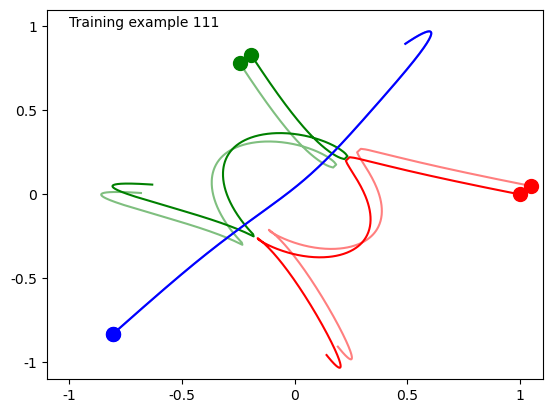

In [171]:
idx = 111
x_instance, y_instance = get_data(data=data, idx=idx)
p1, p2, p3 = get_trajectories(y_instance)

fig, ax = plt.subplots()
ax.annotate(f"Training example {idx}", xy=(-1, 1))
ticks = [-1, -0.5, 0, 0.5, 1]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xlim((-1.1,1.1))
ax.set_ylim((-1.1,1.1))
ax.set_xticklabels(ticks)
ax.set_yticklabels(ticks)

# Plot once for ground truth: y
plot_trajectories(p1+0.05, p2-0.05, p3, ax=ax, label=idx, alpha=0.5)
# Plot once for prediction: yhat
plot_trajectories(p1, p2, p3, ax=ax, label=idx)

### Define own model, loss and optimizer

Design decisions

    1. Weight initialization is a crucial component. For dense layers with relu activation I suggest to use the Kaiming He initialization technique proposed in "Surpassing Human-Level Performance on ImageNet Classification" (ttps://arxiv.org/pdf/1502.01852.pdf)

In [172]:
# Define Sequential MLP network with 3 layers à 128 neurons and an output layer
model = models.Sequential([
    layers.InputLayer(3),
    layers.Dense(128, activation='relu', kernel_initializer=initializers.HeNormal()),
    layers.Dense(128, activation='relu', kernel_initializer=initializers.HeNormal()),
    layers.Dense(128, activation='relu', kernel_initializer=initializers.HeNormal()),
    layers.Dense(128, activation='relu', kernel_initializer=initializers.HeNormal()),
    layers.Dense(4)])                 

# Define Adam optimizer
#optimizer = optimizers.Adam(0.001, 0.5, 0.5)
optimizer = optimizers.Adam()

# Define MAE loss
loss = losses.MeanAbsoluteError()

# Compile our model
model.compile(optimizer=optimizer, loss=loss)

 or load an existing model

In [131]:
# Insert the name of the model you want to load
model_name = "1310_1513"

model = keras.models.load_model(f"./models/NN_project2_{model_name}.h5")
train_loss = load_data = np.load(f'./history/train_{model_name}.npy')
validation_loss = load_data = np.load(f'./history/val_{model_name}.npy')

### Get model summary

In [173]:
# model.build()
# model.summary()

### Fit our model

In [174]:
callback_lr = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

callback_early_stopping = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [183]:
history = model.fit(dataset_train, 
                    epochs=5, 
                    validation_data = dataset_validation,
                    callbacks=[callback_early_stopping,callback_lr],
                    )

Epoch 1/5
  3/618 [..............................] - ETA: 44s - loss: 0.0833

618/618 [==============================] - 43s 70ms/step - loss: 0.0790 - val_loss: 0.0756 - lr: 0.0010
Epoch 2/5
618/618 [==============================] - 42s 68ms/step - loss: 0.0744 - val_loss: 0.0725 - lr: 0.0010
Epoch 3/5
618/618 [==============================] - 45s 73ms/step - loss: 0.0709 - val_loss: 0.0718 - lr: 0.0010
Epoch 4/5
618/618 [==============================] - 55s 89ms/step - loss: 0.0707 - val_loss: 0.0708 - lr: 0.0010
Epoch 5/5
618/618 [==============================] - 42s 68ms/step - loss: 0.0694 - val_loss: 0.0679 - lr: 0.0010


### Save the trained model + history

In [179]:
now = time.datetime.now()
tn = now.strftime('%d%m_%H%M')
tf.keras.models.save_model(model, f"./models/NN_project2_{tn}.h5")
np.save(f"./history/train_{tn}", arr=history.history["loss"])
np.save(f"./history/val_{tn}", arr=history.history["val_loss"])

C:\Users\Linus\AppData\Local\Temp\ipykernel_3016\2792456644.py:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, f"./models/NN_project2_{tn}.h5")


### Test our model

In [180]:
yhat = model.predict(dataset_train)

618/618 [==============================] - 22s 35ms/step


<Axes: >

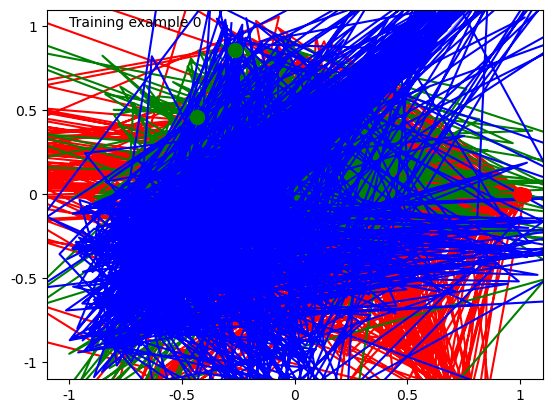

In [184]:
idx = 0
ele = yhat[idx:idx+1000].reshape(1000,4)

_, y_instance = get_data(data=data, idx=idx)

p1_hat, p2_hat, p3_hat = get_trajectories(ele)
p1_gt, p2_gt, p3_gt = get_trajectories(y_instance)

fig, ax = plt.subplots()
ax.annotate(f"Training example {idx}", xy=(-1, 1))
ticks = [-1, -0.5, 0, 0.5, 1]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xlim((-1.1,1.1))
ax.set_ylim((-1.1,1.1))
ax.set_xticklabels(ticks)
ax.set_yticklabels(ticks)

# Plot once for ground truth: y
plot_trajectories(p1_gt, p2_gt, p3_gt, ax=ax, label=idx, alpha=0.5)
# Plot once for prediction: yhat
plot_trajectories(p1_hat, p2_hat, p3_hat, ax=ax, label=idx)

### Get the provided model

In [185]:
pre_trained_model = keras.models.load_model("Breen_NN_project2.h5")

In [186]:
pre_trained_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 128)               512       
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 128)               16512 

Test provided model

In [187]:
idx = 111
input_data = np.hstack((x[idx,:,0].reshape(1000,1),np.full((1000,2),x[idx,0,1:])))
yhat_pre_trained = pre_trained_model.predict(input_data)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [7]:
x_instance, y_instance = get_data(data=data, idx=idx)

p1_hat, p2_hat, p3_hat = get_trajectories(yhat_pre_trained)
p1_gt, p2_gt, p3_gt = get_trajectories(y_instance)

fig, ax = plt.subplots()
ax.annotate(f"Training example {idx}", xy=(-1, 1))
ticks = [-1, -0.5, 0, 0.5, 1]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xlim((-1.1,1.1))
ax.set_ylim((-1.1,1.1))
ax.set_xticklabels(ticks)
ax.set_yticklabels(ticks)

# Plot once for ground truth: y
plot_trajectories(p1_gt, p2_gt, p3_gt, ax=ax, label=idx, alpha=0.5)
# Plot once for prediction: yhat
plot_trajectories(p1_hat, p2_hat, p3_hat, ax=ax, label=idx)

NameError: name 'get_data' is not defined

## Task 2

Show the Mean Absolute Error (MAE) vs epoch from the training of your own ANN (as in Fig. 3 of the paper). I.e. you should show both the MAE metric on the training and the validation data.

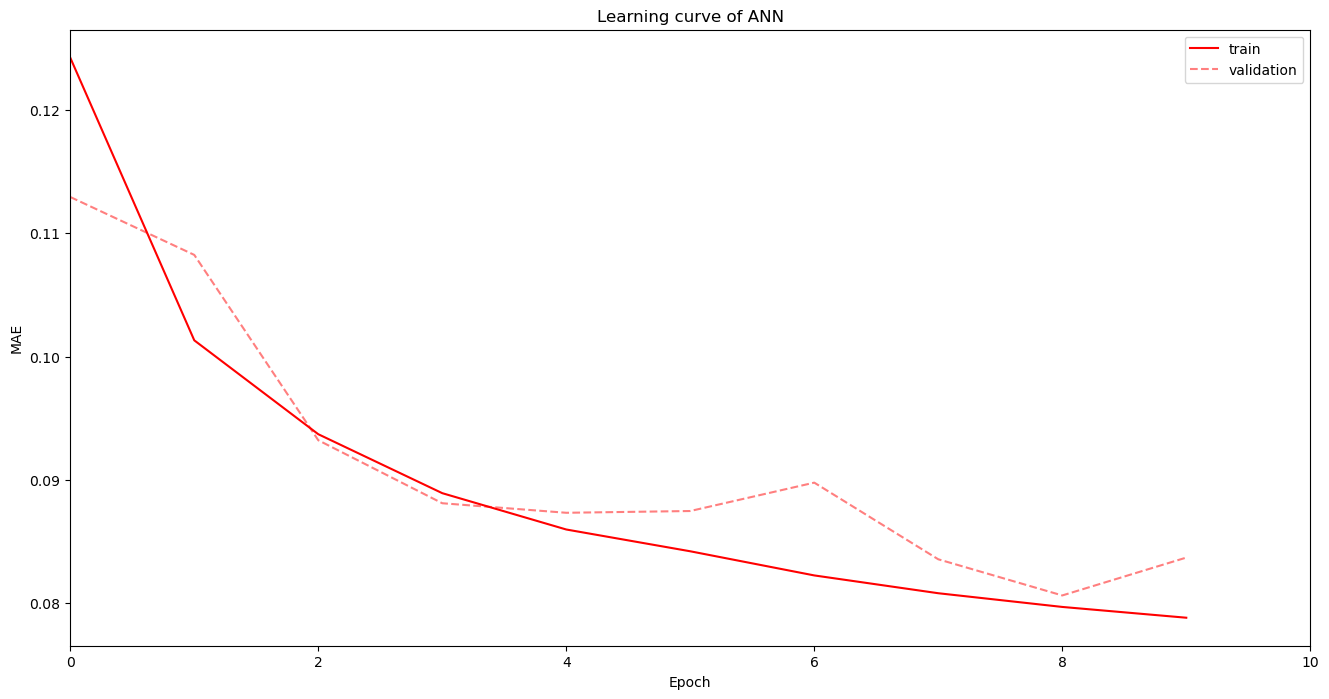

In [26]:
# generate synthetic data

if train:
    train_loss = list(history.history["loss"])
    validation_loss = list(history.history["val_loss"])

# --- plot

fix, ax = plt.subplots(1,1, figsize=(16, 8))

ax.plot(train_loss, color="red", ls="-", label="train")
ax.plot(validation_loss, color="red", ls="--", alpha=0.5, label="validation")
ax.set_xlim([0,len(train_loss)])
ax.set_xticks(np.arange(0,len(train_loss)+len(train_loss)/5,len(train_loss)/5))
ax.set_ylabel("MAE")
ax.set_xlabel("Epoch")
ax.set_title("Learning curve of ANN")
ax.legend()

plt.show()

## Task 3

Check the accuracy of the pre-trained ANN by showing some trajectories and the ANN prediction as in Fig. 4 of the paper. Add also the trajectory of your ANN and comment on its performance. (Note that you should not expect your own ANN to perform as well as the pre-trained one. In addition, the trajectories that are shown in the paper seem to be ones for which the model works very well).

#### Model from the Paper

32/32 [==============================] - 0s 8ms/step


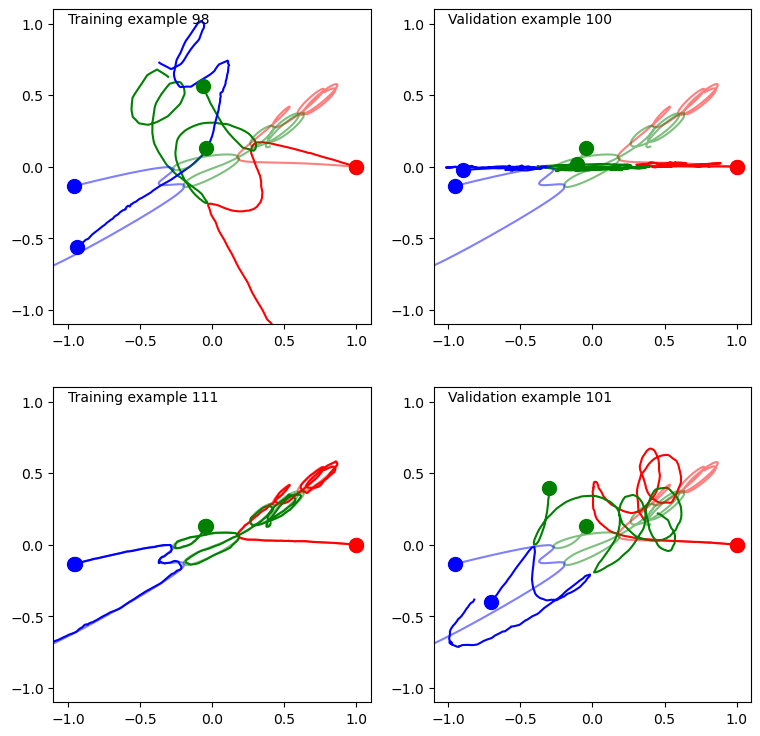

In [106]:
fig, ax = plt.subplots(2,2, figsize=(9,9))

instances = [98,100,111,101]
i = 0

for d1 in ax:
    for element in d1:

        idx = instances[i]

        if i in [0,2]:
            input_data = np.hstack((X_train[idx,:,0].reshape(1000,1),np.full((1000,2),X_train[idx,0,1:])))
            element.annotate(f"Training example {idx}", xy=(-1, 1))
        else: 
            input_data = np.hstack((X_validation[idx,:,0].reshape(1000,1),np.full((1000,2),X_validation[idx,0,1:])))
            element.annotate(f"Validation example {idx}", xy=(-1, 1))

        i+=1
        yhat = pre_trained_model.predict(input_data)

        p1_hat, p2_hat, p3_hat = get_trajectories(yhat)
        p1_gt, p2_gt, p3_gt = get_trajectories(y_instance)

        y_instance = y_train[idx,:,:]
        p1_gt, p2_gt, p3_gt = get_trajectories(y_instance)

        plot_trajectories(p1_hat, p2_hat, p3_hat, ax=element, label=idx)
        plot_trajectories(p1, p2, p3, ax=element, label=idx, alpha=0.5)

        ticks = [-1, -0.5, 0, 0.5, 1]
        element.set_xlim([-1.1,1.1])
        element.set_ylim([-1.1,1.1])
        element.set_xticks(ticks)
        element.set_yticks(ticks)

#### Our model

32/32 [==============================] - 0s 3ms/step


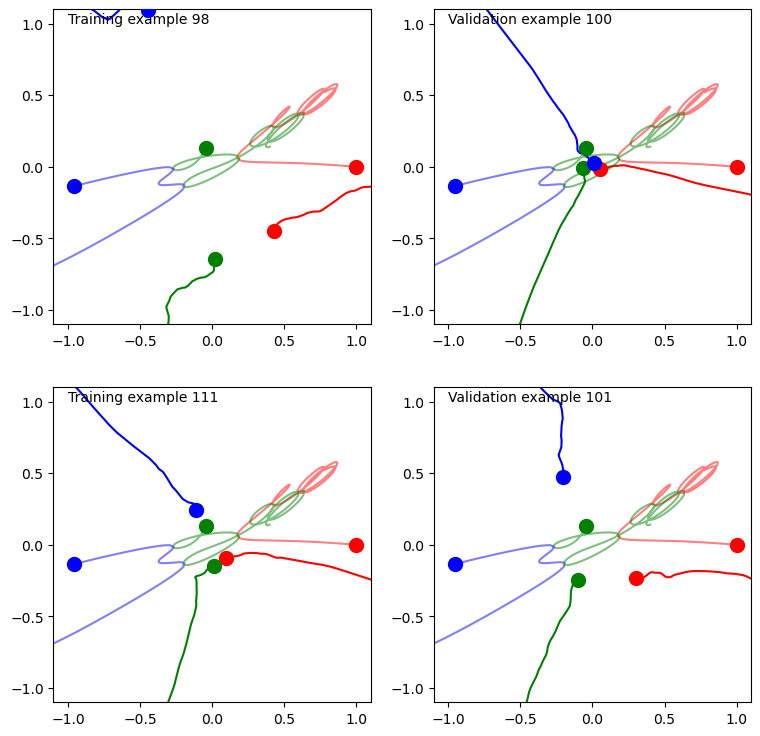

In [105]:
fig, ax = plt.subplots(2,2, figsize=(9,9))

instances = [98,100,111,101]
i = 0

for d1 in ax:
    for element in d1:

        idx = instances[i]

        if i in [0,2]:
            input_data = np.hstack((X_train[idx,:,0].reshape(1000,1),np.full((1000,2),X_train[idx,0,1:])))
            element.annotate(f"Training example {idx}", xy=(-1, 1))
        else: 
            input_data = np.hstack((X_validation[idx,:,0].reshape(1000,1),np.full((1000,2),X_validation[idx,0,1:])))
            element.annotate(f"Validation example {idx}", xy=(-1, 1))

        i+=1
        yhat = model.predict(input_data)

        p1_hat, p2_hat, p3_hat = get_trajectories(yhat)
        p1_gt, p2_gt, p3_gt = get_trajectories(y_instance)

        y_instance = y_train[idx,:,:]
        p1_gt, p2_gt, p3_gt = get_trajectories(y_instance)

        plot_trajectories(p1_hat, p2_hat, p3_hat, ax=element, label=idx)
        plot_trajectories(p1, p2, p3, ax=element, label=idx, alpha=0.5)

        ticks = [-1, -0.5, 0, 0.5, 1]
        element.set_xlim([-1.1,1.1])
        element.set_ylim([-1.1,1.1])
        element.set_xticks(ticks)
        element.set_yticks(ticks)

## Task 4

Check the computational cost of making a prediction with the ANN. You will find that it is much shorter than the numerical integration performed by `Brutus` (which according to the reference takes minutes to hours for finding a trajectory).

    Assume a computation time between 1 minute and 10 hours for Brutus.

    * Computation time Brutus: 60sec - 36000sec


## Task 5

Having access to these ANN emulators you can explore the chaotic aspect of this motion by creating a hundred different trajectories from a slightly disturbed initial condition. Try to reproduce Fig. 5 in the paper (both with the pre-trained and your own ANN).

## Extra Task

* Create a helper function that extracts the velocity at each time step.
* Compute the potential energy and the kinetic energy at each time step. The units are chosen such that the total energy is just the sum of these two.
* Check for the conservation of energy in: (i) the data generated by `Brutus` (note that the velocities are given in the last few columns of the data file); (ii) the pre-trained model from the paper; (iii) your ANN model.
* Create a custom loss function and re-train your model to be trained (constrained) by energy conservation. (Unfortunately, you should not expect any significant improvement in the model with the energy-conserving loss function.)
* Reproduce Fig. 6 (with the green line being replaced by your energy-conserving ANN). 